In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from numba import jit

### Data generation

In [2]:
x_dim = 5 # dimension of observations
num_MBONS = 4
freq = [0.1, 0.1, 0.1, 0.1, 0.6]
mus = []

for i in range(num_MBONS+1):
    mus.append(10*np.random.randn(x_dim,1))
    
sig = np.random.randn(x_dim,x_dim)/np.sqrt(x_dim)
Sigma = sig@sig.T
samples = 100000 # number of data points

In [3]:
classes = []
for i in range(num_MBONS+1):
    classes.append(mus[i] + sig@np.random.randn(x_dim,int(samples*freq[i])))

In [4]:
X = np.concatenate(classes, axis=1)
Y = np.zeros((num_MBONS-1, 2,samples))

for i in range(1, num_MBONS):
    Y[i-1, 0, :i*int(samples*freq[i])] = 1
    Y[i-1, 0, (i+1)*int(samples*freq[i]):] = 1
    Y[i-1, 1, i*int(samples*freq[i]):(i+1)*int(samples*freq[i])] = 1
    
idx = np.random.permutation(samples)
X = X[:,idx]
for i in range(num_MBONS-1):
    Y[i] = Y[i][:,idx]

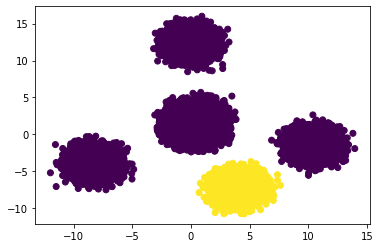

In [5]:
plt.scatter(X[0],X[1], c = Y[0,1])
plt.show()

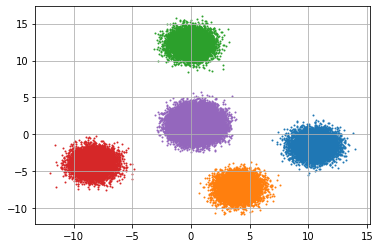

In [6]:
for i in range(num_MBONS+1):
    plt.scatter(classes[i][0],classes[i][1],s=1)
plt.grid()
plt.show()

### MBONs solution

In [7]:
@jit(nopython=True)
def eta(t):
    return 5e-4/(1+5e-4*t)

gam = 1000; epochs = 10; iters = epochs*samples

@jit(nopython=True)
def fit_sparse(w, l, mu, b, x, y, t):
    z = w.T@x

    b = max(b + (y[1]-b)/t,1e-5)

    mu += (x - mu)/t
    nu = w.T@mu

    step = eta(t)

    w += step*(x - l*(z-nu)*(x-mu)) - step*y[1]*x/b
    l += gam*step*((z-nu)**2 - 1)
    
    return w, l, mu, b, x, y

def run_sparse(X, Y):
    
    w = np.random.randn(x_dim)/np.sqrt(x_dim)
    l = 1
    
    mu = np.zeros(x_dim)

    b = 0.5

    for i_epoch in tqdm(range(epochs)):

        idx = np.random.permutation(samples)

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            w, l, mu, b, x, y = fit_sparse(w, l, mu, b, x, y, t)
            
            obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
            err_approx[i_iter] = abs(obj_opt - obj[i_iter])/obj_opt
        
        #print(f'Error: {err_approx[i_iter]}')
    return w

#eta = 0.001; gam = 1000*eta; iters = 10000

@jit(nopython=True)
def fit(w, l, mu_1, mu_2, Sigma):
    w = w + eta*(mu_1 - mu_2 - l*Sigma@w)
    l = l + gam*((w.T@Sigma@w).item() - 1)
    
    return w, l
        
def run_offline(mu_1, mu_2, Sigma, eta, gamma, iters):
    
    w = np.random.randn(x_dim,1)/np.sqrt(x_dim)
    l = 1
    
    for i_iter in tqdm(range(iters)):
        w, l = fit(w, l, mu_1, mu_2, Sigma)
        obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
        err[i_iter] = (obj_opt - obj[i_iter])/obj_opt

    return w

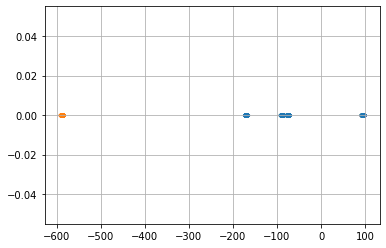

  0%|          | 0/10 [00:00<?, ?it/s]/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in square
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in matmul
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in matmul
100%|██████████| 10/10 [00:14<00:00,  1.35s/it]


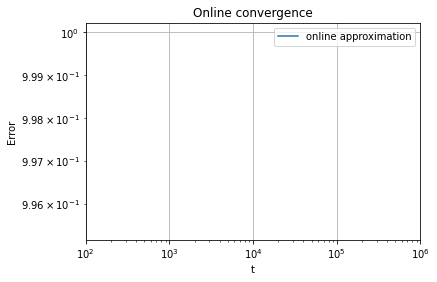

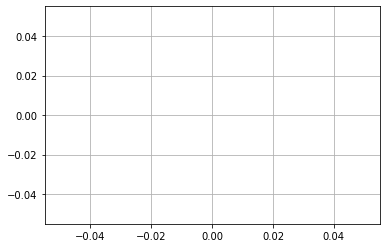

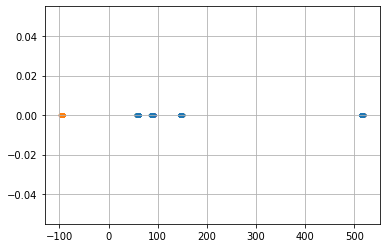

  0%|          | 0/10 [00:00<?, ?it/s]/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in square
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in matmul
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in matmul
100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


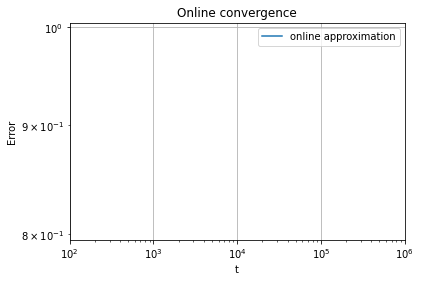

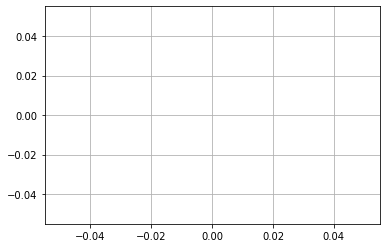

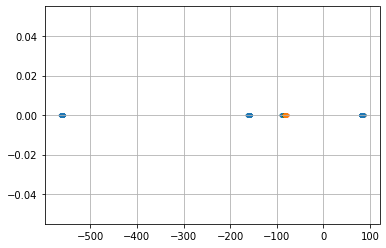

  0%|          | 0/10 [00:00<?, ?it/s]/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in square
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in matmul
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in matmul
100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


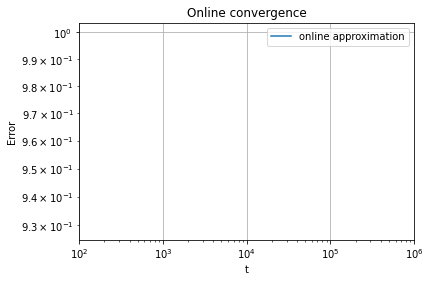

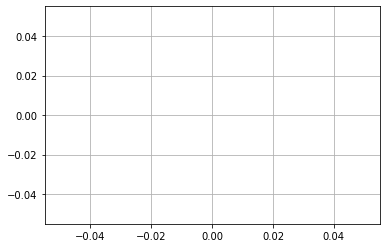

In [8]:
for i in range(1, num_MBONS):
    mu_1 = np.mean([mu for j, mu in enumerate(mus) if j != i ])
    mu_2 = mus[i]
    
    w_opt = np.linalg.inv(Sigma)@(mu_1-mu_2)
    w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)
    obj_opt = (w_opt.T@(mu_1-mu_2))**2
    
    class_1 = np.concatenate([cl for j, cl in enumerate(classes) if j != i ], axis=1)
    class_2 = classes[i]
    
    plt.scatter(w_opt.T@class_1,np.zeros((w_opt.T@class_1).shape),s=5)
    plt.scatter(w_opt.T@class_2,np.zeros((w_opt.T@class_2).shape),s=5)
    plt.grid()
    plt.show()
    
    

    obj = np.zeros(iters)
    err_approx = np.zeros(iters)

    
    w = run_sparse(X,Y[i-1])
    plt.loglog(range(iters), err_approx, label='online approximation')
    plt.ylabel("Error")
    plt.xlabel("t")
    plt.xlim(1e2,iters)
    plt.grid()
    plt.legend()
    plt.title("Online convergence")
    plt.show()
    
    plt.scatter(w.T@class_1,np.zeros((w.T@class_1).shape),s=5)
    plt.scatter(w.T@class_2,np.zeros((w.T@class_2).shape),s=5)
    plt.grid()
    plt.show()